In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist, euclidean
from scipy.stats import spearmanr
from collections import defaultdict
import seaborn as sns
from scipy.spatial import procrustes

In [3]:

# --- SETTINGS ---
DATA_DIR = "experiment_responses/"  # folder with 14 JSON files
N_CELLS = 9

GRID_CELLS = sorted([
    "cell_00", "cell_01", "cell_02",
    "cell_10", "cell_11", "cell_12",
    "cell_20", "cell_21", "cell_22"
])
cell_to_index = {cell: i for i, cell in enumerate(GRID_CELLS)}

In [4]:
# --- LOAD AND PROCESS ---
def load_responses(path):
    matrices = []
    metadata = []

    for fname in os.listdir(path):
        if not fname.endswith(".json"): continue
        with open(os.path.join(path, fname)) as f:
            data = json.load(f)

        mat = np.zeros((9, 9))
        count = np.zeros((9, 9))

        for trial in data["responses"]:
            i = cell_to_index[trial["cell1"]]
            j = cell_to_index[trial["cell2"]]
            rating = trial["rating"]
            mat[i, j] = rating
            mat[j, i] = rating
            count[i, j] += 1
            count[j, i] += 1

        # Fill diagonal
        np.fill_diagonal(mat, 7)
        matrices.append(mat)
        metadata.append(data.get("end_responses", {}))
    return matrices, metadata

def average_matrix(matrices):
    return np.nanmean(matrices, axis=0)

def plot_mds(sim_matrix, labels, title):
    dissim = 7 - sim_matrix  # similarity to dissimilarity
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(dissim)

    plt.figure(figsize=(7, 6))
    plt.scatter(coords[:, 0], coords[:, 1])
    for i, label in enumerate(labels):
        plt.text(coords[i, 0] + 0.01, coords[i, 1] + 0.01, label, fontsize=9)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_matrix(mat, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(mat, cmap='viridis', vmin=1, vmax=7)
    plt.colorbar(label='Rating')
    plt.title(title)
    plt.xticks(range(9), GRID_CELLS, rotation=45)
    plt.yticks(range(9), GRID_CELLS)
    plt.tight_layout()
    plt.show()

def split_groups(matrices, metadata):
    musicians = []
    non_musicians = []
    for mat, meta in zip(matrices, metadata):
        if meta.get("formal-training", "").lower() == "yes":
            musicians.append(mat)
        else:
            non_musicians.append(mat)
    return musicians, non_musicians

In [5]:
matrices, metadata = load_responses(DATA_DIR)


In [7]:
from datetime import datetime
import numpy as np

def analyze_response_times(participant_data):
    all_total_times = []
    all_mean_trial_times = []
    all_median_trial_times = []

    for p_idx, data in enumerate(participant_data):
        timestamps = [
            datetime.fromisoformat(trial["timestamp"].replace("Z", ""))
            for trial in data.get("responses", [])
        ]
        if len(timestamps) < 2:
            continue  # skip incomplete

        # Ensure timestamps are sorted
        timestamps.sort()
        deltas = np.diff(timestamps)
        trial_times_sec = np.array([delta.total_seconds() for delta in deltas])

        total_time_sec = (timestamps[-1] - timestamps[0]).total_seconds()
        mean_time = np.mean(trial_times_sec)
        median_time = np.median(trial_times_sec)

        all_total_times.append(total_time_sec)
        all_mean_trial_times.append(mean_time)
        all_median_trial_times.append(median_time)

        # print(f"\nParticipant {p_idx + 1}:")
        # print(f"  Total time: {total_time_sec:.2f} seconds ({total_time_sec/60:.2f} min)")
        # print(f"  Mean time per trial: {mean_time:.2f} sec")
        # print(f"  Median time per trial: {median_time:.2f} sec")

    total_sec = np.mean(all_total_times)
    median_total_sec = np.median(all_total_times)
    print("\n--- Summary Across All Participants ---")
    print(f"Average total time: {total_sec:.2f} sec = {total_sec/60:.2f} min")
    print(f"Median total time: {median_total_sec:.2f} sec = {median_total_sec/60:.2f} min")
    print(f"Average mean trial time: {np.mean(all_mean_trial_times):.2f} sec")
    print(f"Average median trial time: {np.mean(all_median_trial_times):.2f} sec")

participant_data = [json.load(open(DATA_DIR+f)) for f in os.listdir(DATA_DIR)]
analyze_response_times(participant_data)


--- Summary Across All Participants ---
Average total time: 1259.67 sec = 20.99 min
Median total time: 548.87 sec = 9.15 min
Average mean trial time: 35.99 sec
Average median trial time: 15.66 sec


In [ ]:

mus, nonmus = split_groups(matrices, metadata)

avg_all = average_matrix(matrices)
avg_mus = average_matrix(mus)
avg_non = average_matrix(nonmus)

# Plot matrices
plot_matrix(avg_all, "Average Similarity Matrix: All Participants")
plot_matrix(avg_mus, "Average Similarity Matrix: Musicians")
plot_matrix(avg_non, "Average Similarity Matrix: Non-Musicians")

# # Save CSVs
# pd.DataFrame(avg_all, index=GRID_CELLS, columns=GRID_CELLS).to_csv("grid_similarity_all.csv")
# pd.DataFrame(avg_mus, index=GRID_CELLS, columns=GRID_CELLS).to_csv("grid_similarity_musicians.csv")
# pd.DataFrame(avg_non, index=GRID_CELLS, columns=GRID_CELLS).to_csv("grid_similarity_nonmusicians.csv")

# Plot
plot_mds(avg_all, GRID_CELLS, "MDS: All Participants (Grid-Cell Similarity)")
plot_mds(avg_mus, GRID_CELLS, "MDS: Musicians Only")
plot_mds(avg_non, GRID_CELLS, "MDS: Non-Musicians Only")

# Correlations
def upper_tri_flat(m):
	return m[np.triu_indices_from(m, k=1)]

print("Musician vs Non-Musician (Spearman):",
		spearmanr(upper_tri_flat(avg_mus), upper_tri_flat(avg_non)).correlation)

print("All vs Musicians:", spearmanr(upper_tri_flat(avg_all), upper_tri_flat(avg_mus)).correlation)
print("All vs Non-Musicians:", spearmanr(upper_tri_flat(avg_all), upper_tri_flat(avg_non)).correlation)

Compare perceptual similarity (between 9 grid cells) with the average pairwise distances of the corresponding ragas in the computational raga space

In [31]:
TSNE_FILE = "2dTSNE.json"
# TSNE_FILE = "MDS.json"

# --- Step 1: Load TSNE Embeddings ---
def load_tsne(tsne_file):
    with open(tsne_file) as f:
        data = json.load(f)
    raga_to_coords = {entry["raga"]: (entry["x"], entry["y"]) for entry in data}
    return raga_to_coords

# --- Step 2: Map each grid cell to list of raga coordinates ---
def collect_cell_embeddings(responses_dir, raga_to_coords):
    cell_coords = {cell: [] for cell in GRID_CELLS}
    cell_ragas = {cell: [] for cell in GRID_CELLS}

    for fname in os.listdir(responses_dir):
        if not fname.endswith(".json"): continue
        with open(os.path.join(responses_dir, fname)) as f:
            data = json.load(f)
        for cell, raga in data["selected_ragas"].items():
            if raga in raga_to_coords:
                cell_coords[cell].append(raga_to_coords[raga])
                cell_ragas[cell].append(raga)
    return cell_coords, cell_ragas

# --- Step 3: Compute centroid per cell ---
def compute_centroids(cell_coords):
    centroids = {}
    for cell, coords in cell_coords.items():
        if coords:
            x_mean = np.mean([pt[0] for pt in coords])
            y_mean = np.mean([pt[1] for pt in coords])
            centroids[cell] = (x_mean, y_mean)
        else:
            centroids[cell] = (np.nan, np.nan)
    return centroids

# --- Step 4: Compute 9x9 distance matrix ---
def compute_distance_matrix(centroids):
    dist_matrix = np.zeros((9, 9))
    cells = GRID_CELLS
    for i, ci in enumerate(cells):
        for j, cj in enumerate(cells):
            if i == j:
                dist = 0
            else:
                dist = euclidean(centroids[ci], centroids[cj])
            dist_matrix[i, j] = dist
    return dist_matrix

# --- Step 5: Correlate with perceptual similarity ---
def load_perceptual_similarity(file="grid_similarity_all.csv"):
    return avg_all

def upper_tri_flat(m):
    return m[np.triu_indices_from(m, k=1)]


In [32]:
DATA_FILE = "2dTSNE.json"

df = pd.read_json(DATA_FILE)

df["source"] = df["raga"].str.split("_").str[0]
df["source_raga"] = df["raga"]
df["raga"] = df["raga"].str.split("_").str[1]

df["seq_octaveless"] = df["seq"].str.replace(".", "").str.replace("'", "")

df["seq_len"] = df["seq"].str.len()

df.head()

,x,y,raga,seq,source,source_raga,seq_octaveless,seq_len
0,4.640824,-0.012556,abhogi kanada,srGmd's'sdmGrGmrsr.d.dsrmdssr.dsrGmGmrsGmrsGmr...,H,H_abhogi kanada,srGmdssdmGrGmrsrddsrmdssrdsrGmGmrsGmrsGmrsmGrs...,85
1,21.711260,4.014056,adana,srmpDNssDNpmpGmrssDNsDNpmpGmrsmmpsDNpmmpDNssDN...,H,H_adana,srmpDNssDNpmpGmrssDNsDNpmpGmrsmmpsDNpmmpDNssDN...,465
2,16.856970,-9.628291,ahir bhairav,sRgmpdNssNdpmgmRRsgmRRsNdNRRsmgmRsssRgmmpgmgmp...,H,H_ahir bhairav,sRgmpdNssNdpmgmRRsgmRRsNdNRRsmgmRsssRgmmpgmgmp...,705
3,-13.788297,7.972342,alhaiya bilawal,sgp'spggrgpdNdpmgrgpdn'ssrgpdn's'sndpdNdpmgrs'...,H,H_alhaiya bilawal,sgpspggrgpdNdpmgrgpdnssrgpdnssndpdNdpmgrssndpd...,646
4,-4.497239,16.141819,arabi,s.dsrmgrpmppp's'sdmpddmrgrs.dsrmgrpmppp's'sdmp...,H,H_arabi,sdsrmgrpmpppssdmpddmrgrsdsrmgrpmpppssdmpddmrgr...,119


In [33]:
from tokenize_seq import tokenize_seq
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenize_seq, lowercase=False, ngram_range=(3,5))

# Fit and transform the sequences
X = vectorizer.fit_transform(df["seq"])

# Convert TF-IDF matrix to dense array
X_array = X.toarray()

print(X_array.shape)

def compute_distance_matrix_tfidf(cell_ragas):
	dist_matrix = np.zeros((9, 9))
	cells = GRID_CELLS
	for i, ci in enumerate(cells):
		for j, cj in enumerate(cells):
			if i == j:
				dist = 0
			else:
				# Get the indices of the selected ragas for each cell
				raga_indices_i = [df[df["source_raga"] == raga].index[0] for raga in cell_ragas[ci]]
				raga_indices_j = [df[df["source_raga"] == raga].index[0] for raga in cell_ragas[cj]]
				
				# Compute the distance using TF-IDF vectors
				dist = euclidean(X_array[raga_indices_i].mean(axis=0), X_array[raga_indices_j].mean(axis=0))
			dist_matrix[i, j] = dist
	return dist_matrix

/home/soham/miniconda3/envs/csai/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(379, 82660)


In [34]:

# --- MAIN ---
print("Loading TSNE data and participant responses...")
raga_coords = load_tsne(TSNE_FILE)
cell_embeddings, cell_ragas = collect_cell_embeddings(DATA_DIR, raga_coords)
centroids = compute_centroids(cell_embeddings)
tsne_distance_matrix = compute_distance_matrix(centroids)
# tsne_distance_matrix = compute_distance_matrix_tfidf(cell_ragas)

print("Loading perceptual similarity matrix...")
perceptual_matrix = load_perceptual_similarity()

# Convert similarity to dissimilarity
perceptual_dissim = 7 - perceptual_matrix

# Correlation
tsne_flat = upper_tri_flat(tsne_distance_matrix)
percept_flat = upper_tri_flat(perceptual_dissim)
corr = spearmanr(tsne_flat, percept_flat).correlation

print("Spearman correlation between TSNE distances and perceptual dissimilarity:", round(corr, 4))

# # Save comparison matrices
# pd.DataFrame(tsne_distance_matrix, index=GRID_CELLS, columns=GRID_CELLS).to_csv("grid_distance_tsne.csv")


Loading TSNE data and participant responses...
Loading perceptual similarity matrix...
Spearman correlation between TSNE distances and perceptual dissimilarity: 0.5081


In [35]:
def plot_heatmaps(percept_dissim, tsne_dissim, labels):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(percept_dissim, xticklabels=labels, yticklabels=labels,
                ax=axes[0], cmap="YlGnBu", square=True, cbar_kws={"label": "Dissimilarity"})
    axes[0].set_title("Perceptual Dissimilarity (7 - rating)")

    sns.heatmap(tsne_dissim, xticklabels=labels, yticklabels=labels,
                ax=axes[1], cmap="YlOrRd", square=True, cbar_kws={"label": "Distance"})
    axes[1].set_title("Computational Dissimilarity (t-SNE)")

    plt.tight_layout()
    plt.show()

def plot_procrustes(percept_matrix, tsne_centroids, labels):
    from sklearn.manifold import MDS

    dissim = 7 - percept_matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(dissim)

    tsne_coords = np.array([tsne_centroids[cell] for cell in labels])

    # Run Procrustes analysis
    mtx1, mtx2, disparity = procrustes(mds_coords, tsne_coords)

    plt.figure(figsize=(8,6))
    plt.plot(mtx1[:, 0], mtx1[:, 1], 'o-', label="Perceptual MDS", color='blue')
    plt.plot(mtx2[:, 0], mtx2[:, 1], 's--', label="t-SNE Centroids", color='red')

    for i, label in enumerate(labels):
        plt.text(mtx1[i, 0]+0.01, mtx1[i, 1]+0.01, label, color='blue', fontsize=9)
        plt.text(mtx2[i, 0]+0.01, mtx2[i, 1]+0.01, label, color='red', fontsize=9)

    plt.title("Procrustes Alignment: Perceptual MDS vs t-SNE Centroids")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Generating visualizations...


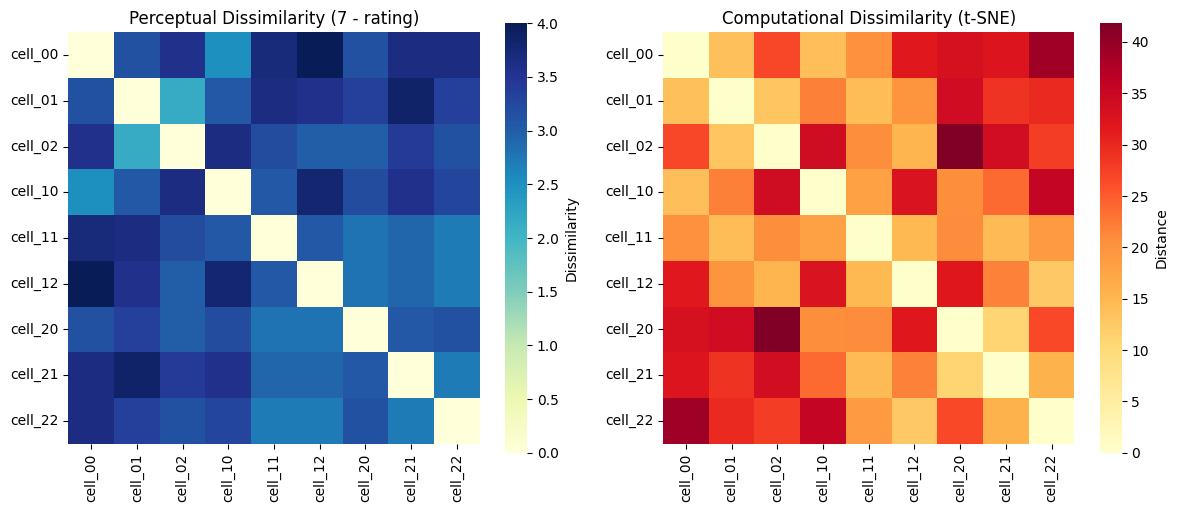

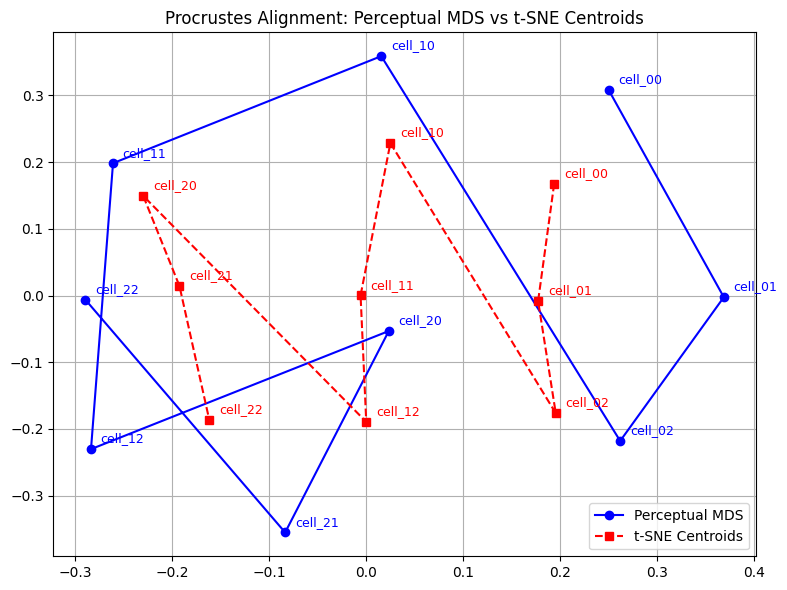

In [36]:
print("\nGenerating visualizations...")
plot_heatmaps(perceptual_dissim, tsne_distance_matrix, GRID_CELLS)
plot_procrustes(perceptual_matrix, centroids, GRID_CELLS)